In [17]:
!pip install tf-nightly

  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.


In [2]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly 2.19.0.dev20250206 requires ml-dtypes<1.0.0,>=0.5.1, but you have ml-dtypes 0.4.1 which is incompatible.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet
import tensorflow as tf
import keras
import zipfile
from IPython import get_ipython
from IPython.display import display

In [2]:
ROOT_DIR = '/content/drive/MyDrive/FrostHack_Dataset/PCOS'
train_dir = os.path.join(ROOT_DIR, "train")
test_dir = os.path.join(ROOT_DIR, "test")
number_of_images = {}

for dir in os.listdir(train_dir):
   number_of_images[dir] = len(os.listdir(os.path.join(train_dir,dir)))
   print("",dir,"" ,number_of_images[dir])

for dir in os.listdir(test_dir):
   number_of_images[dir] = len(os.listdir(os.path.join(test_dir,dir)))
   print("",dir,"" ,number_of_images[dir])

 notinfected  1143
 infected  781
 notinfected  1141
 infected  781


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

In [4]:
def preprocessingImage1(path):
  image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,horizontal_flip=True,preprocessing_function=preprocess_input)
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image # Added return statement to return the image object

In [5]:
def preprocessingImage2(path):
  """

  Input: path
  Output: preprocessed image
  """
  image_data=ImageDataGenerator(preprocessing_function=preprocess_input)
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')

  return image

In [6]:
path='/content/drive/MyDrive/FrostHack_Dataset/PCOS/train'
train_data=preprocessingImage1(path)

Found 1924 images belonging to 2 classes.


In [7]:
path='/content/drive/MyDrive/FrostHack_Dataset/PCOS/test'
test_data=preprocessingImage1(path)


Found 1922 images belonging to 2 classes.


In [8]:
base_model=MobileNet(input_shape=(224,224,3),include_top=False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
for layer in base_model.layers:
  layer.trainable=False

In [10]:
from keras.layers import Dropout

x= Flatten()(base_model.output)
x= Dropout(0.7)(x)
x= Dense(units=1,activation='sigmoid')(x)

model= Model(base_model.input,x)

model.compile(optimizer='rmsprop',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])


In [11]:
import os
from PIL import Image

def check_and_remove_invalid_images(directory):
    invalid_files = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)


        if not os.path.isfile(filepath):
            print(f"Skipped directory or non-file: {filepath}")
            continue


        if os.path.getsize(filepath) == 0:
            invalid_files.append(filepath)
            os.remove(filepath)
            print(f"Removed empty file: {filepath}")
            continue


        try:
            with Image.open(filepath) as img:
                img.verify()
        except (IOError, Exception) as e:
            invalid_files.append(filepath)
            os.remove(filepath)
            print(f"Removed invalid image: {filepath}")
    return invalid_files


invalid_files = check_and_remove_invalid_images(test_dir)

if invalid_files:
    print("\nInvalid files were found and removed:")
    for file_path in invalid_files:
        print(file_path)
else:
    print("No invalid files found.")


Skipped directory or non-file: /content/drive/MyDrive/FrostHack_Dataset/PCOS/test/notinfected
Skipped directory or non-file: /content/drive/MyDrive/FrostHack_Dataset/PCOS/test/infected
No invalid files found.


In [12]:
import tensorflow as tf

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)


test_data = test_data.map(lambda x, y: (x / 255.0, y))


Found 1922 files belonging to 2 classes.


In [13]:
import os

for root, dirs, files in os.walk(test_dir):
    print(f"Directory: {root}, Number of files: {len(files)}")


Directory: /content/drive/MyDrive/FrostHack_Dataset/PCOS/test, Number of files: 0
Directory: /content/drive/MyDrive/FrostHack_Dataset/PCOS/test/notinfected, Number of files: 1141
Directory: /content/drive/MyDrive/FrostHack_Dataset/PCOS/test/infected, Number of files: 781


In [14]:
from PIL import Image
import os

def check_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            try:
                img = Image.open(filepath)
                img.verify()  # Verify image integrity
            except Exception as e:
                print(f"Invalid image found: {filepath}, Error: {e}")
                os.remove(filepath)  # Optionally remove the file

check_images(test_dir)

In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

# Load dataset and split into training and validation
dataset_path = "/content/drive/MyDrive/FrostHack_Dataset/PCOS/train"
train_data = image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),        # Resize images
    batch_size=32,               # Batch size
    validation_split=0.2,        # Reserve 20% for validation
    subset="training",           # Specify this subset as training
    seed=123                     # Set a seed for reproducibility
)

val_data = image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="validation",         # Specify this subset as validation
    seed=123
)

Found 1924 files belonging to 2 classes.
Using 1540 files for training.
Found 1924 files belonging to 2 classes.
Using 384 files for validation.


In [16]:
train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
val_data = val_data.map(lambda x, y: (preprocess_input(x), y))

In [17]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
mc = ModelCheckpoint(filepath="/content/drive/MyDrive/bestmodel.keras",monitor='val_accuracy',verbose=1,save_best_only=True)

es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5,verbose=1)

cb = [mc,es]

In [18]:
hist = model.fit(
  train_data,
  steps_per_epoch=10,
  epochs=30,
  validation_data=val_data,
  validation_steps=16,
  callbacks=cb
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7908 - loss: 1.2413

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/bestmodel.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 96s 10s/step - accuracy: 0.7999 - loss: 1.1971 - val_accuracy: 1.0000 - val_loss: 3.5442e-05
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 7.2807e-04
Epoch 2: val_accuracy did not improve from 1.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - accuracy: 1.0000 - loss: 7.7097e-04 - val_accuracy: 1.0000 - val_loss: 6.6875e-06
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0029
Epoch 3: val_accuracy did not improve from 1.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 7s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 3.3959e-06
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 8.5617e-07
Epoch 4: val_accuracy did not improve from 1.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 1.0000 - loss: 8.5432e-07 - val_accuracy: 1.0000 - val_loss: 3.3284e

In [19]:
model = load_model("/content/drive/MyDrive/bestmodel.keras")

In [ ]:
  acc = model.evaluate(test_data)[1]
print(f"our model accuracy is  {acc * 100} %")

48/61 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 1.0000 - loss: 4.4856e-05

In [21]:
from keras.preprocessing import image
import tensorflow as tf


def predictimage(path):

      img = tf.keras.utils.load_img(path,target_size=(224,224))
      i = tf.keras.utils.img_to_array(img)/255
      input_arr= np.array([i])
      input_arr.shape

      pred =model.predict(input_arr)
      if pred == 1:
          print("Not Affected")
      else :
         print("Affected")
      #display image
      plt.imshow(input_arr[0],vmin=0, vmax=255)
      plt.title("input Image")
      plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Not Affected


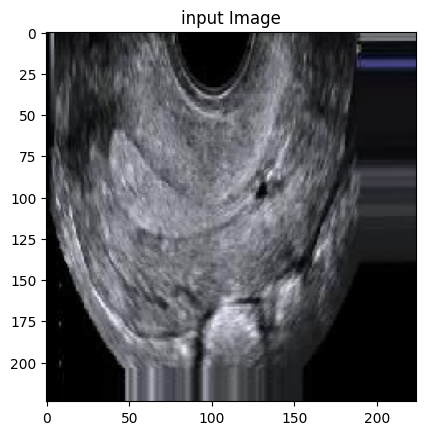

In [22]:
predictimage("/content/drive/MyDrive/FrostHack_Dataset/PCOS/test/notinfected/img_0_1843.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Affected


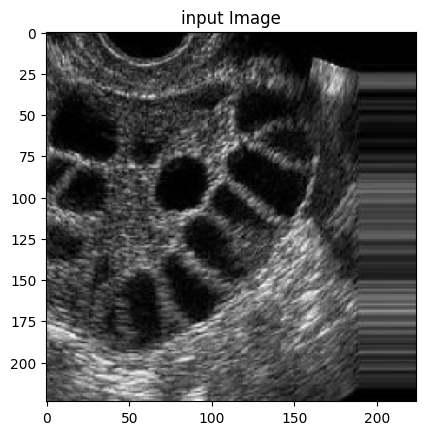

In [23]:
predictimage("/content/drive/MyDrive/FrostHack_Dataset/PCOS/test/infected/img_0_1313.jpg")